In [1]:
# Packages:
import torch
import matplotlib.pyplot as plt

In [2]:
# We're going to recreate the same plot a whole bunch of times, so I'm going to group
# the similar commands into one helper function

def plot_helper():
    plt.figure(figsize=(12,4))
    plt.xlim(-10,801)
    plt.grid(True)
    plt.xlabel("x")
    plt.ylabel("sin(x)")
    plt.title("Sine Wave")

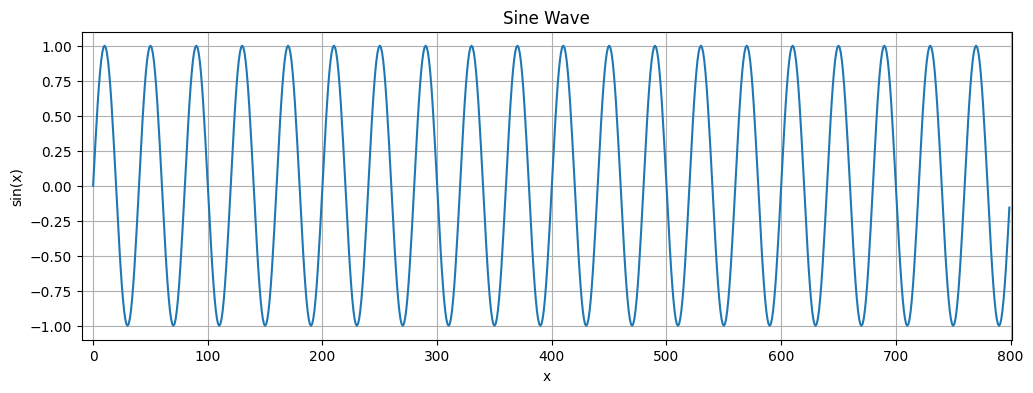

In [30]:
# Create a sine wave
indices = torch.linspace(0,799,800)
y = torch.sin(indices*2*3.1416/40)
num_datums = len(indices)

plot_helper()
plt.plot(indices, y)
plt.show()

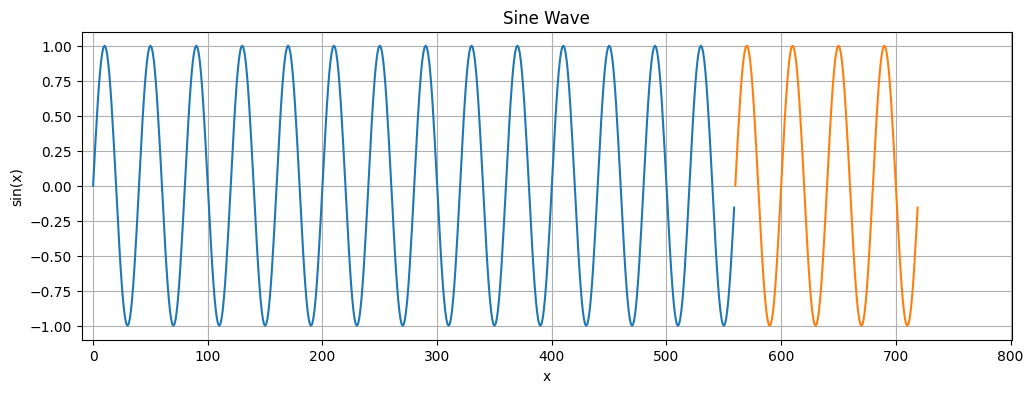

In [4]:
num_train_datums = round( 0.7 * num_datums )
train_inds = indices[:num_train_datums]
train_y = y[:num_train_datums]

num_test_datums = round( 0.2 * num_datums )
test_inds = indices[num_train_datums:num_train_datums+num_test_datums]
test_y = y[num_train_datums:num_train_datums+num_test_datums]

plot_helper()
plt.plot(train_inds, train_y)
plt.plot(test_inds, test_y)
plt.show()

In [15]:
sequence_length = 40
num_sequences = len(train_inds) - sequence_length - 1

training_sequences = []
for i in range(num_sequences):
    sequence = train_y[i:i+sequence_length]
    label = train_y[i+sequence_length]
    training_sequences.append( (sequence, label) )
    


In [16]:
class LSTM(torch.nn.Module):
    
    def __init__(self,input_size = 1, hidden_size = 50, out_size = 1):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = torch.nn.LSTM(input_size, hidden_size)
        self.linear = torch.nn.Linear(hidden_size,out_size)
        self.hidden = (torch.zeros(1,1,hidden_size),torch.zeros(1,1,hidden_size))
    
    def forward(self,seq):
        lstm_out, self.hidden = self.lstm(seq.view(len(seq),1,-1), self.hidden)
        pred = self.linear(lstm_out.view(len(seq),-1))
        return pred[-1]

In [39]:
torch.manual_seed(42)
model = LSTM()

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.14)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Try the Adam optimizer, it is interesting. Why do you think it behaves the way it does?

/Users/joel-carlson/miniconda3/envs/ML/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 Loss: 0.008725414052605629


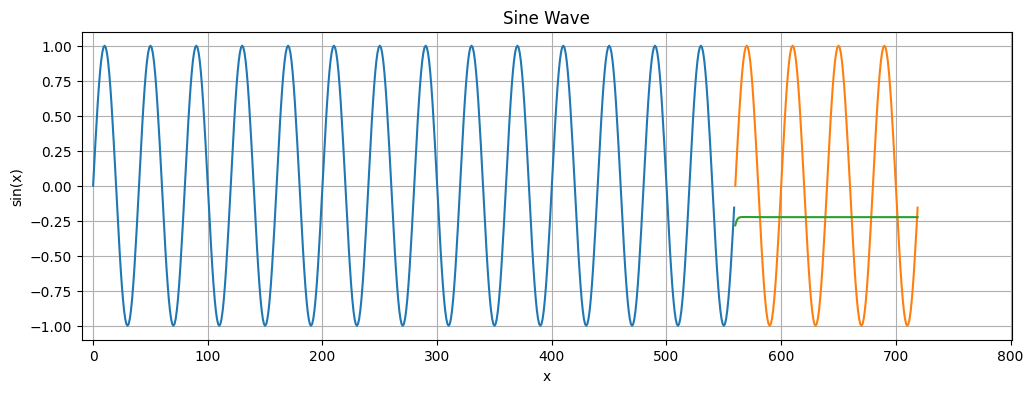

Epoch 1 Loss: 0.01855180598795414


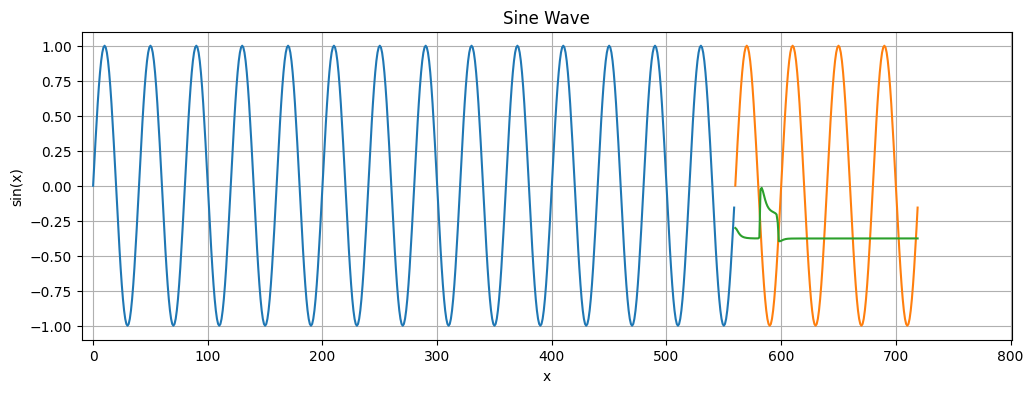

Epoch 2 Loss: 0.009014420211315155


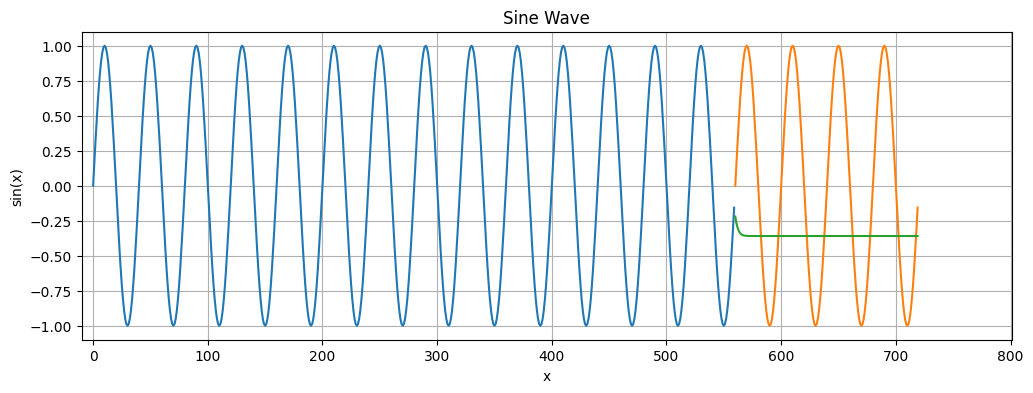

Epoch 3 Loss: 0.0005002134130336344


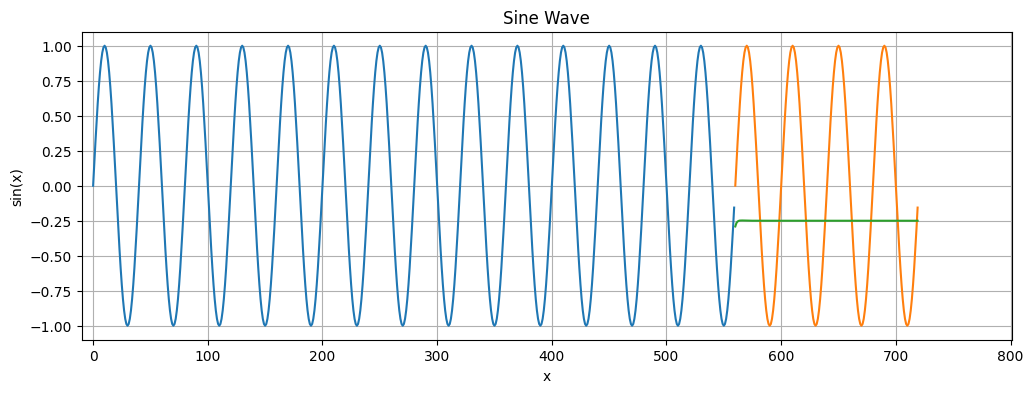

Epoch 4 Loss: 0.00874780211597681


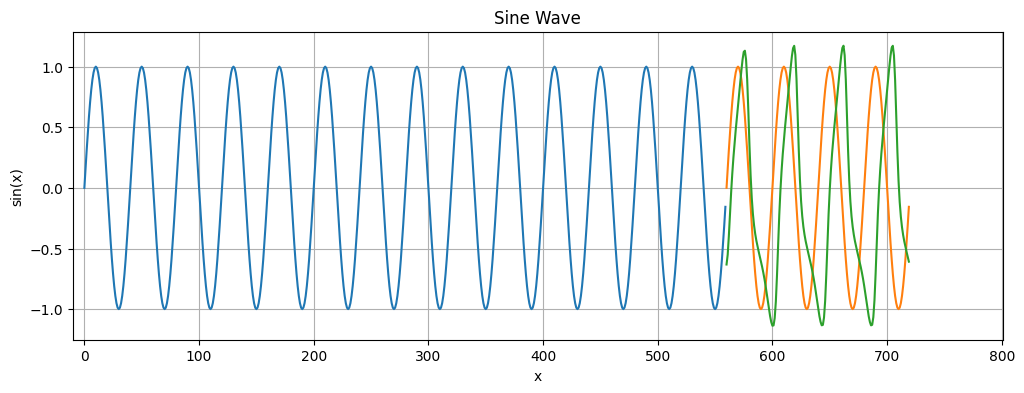

Epoch 5 Loss: 0.021725527942180634


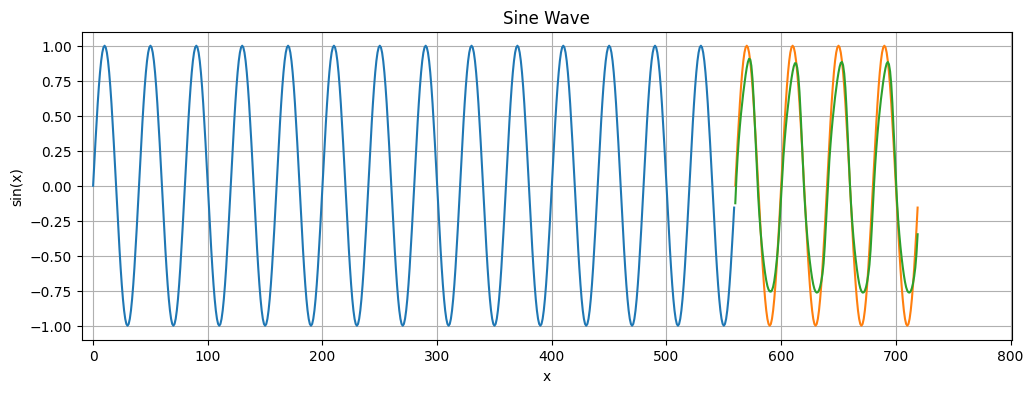

Epoch 6 Loss: 0.00010470178676769137


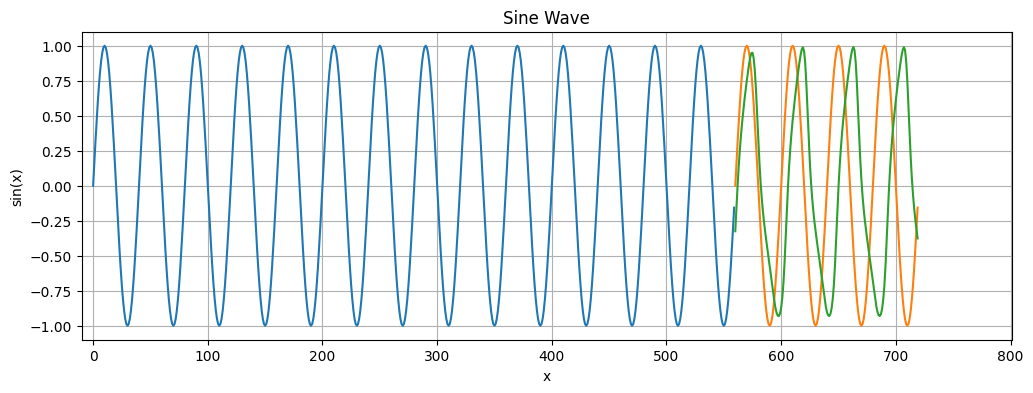

Epoch 7 Loss: 9.022446465678513e-05


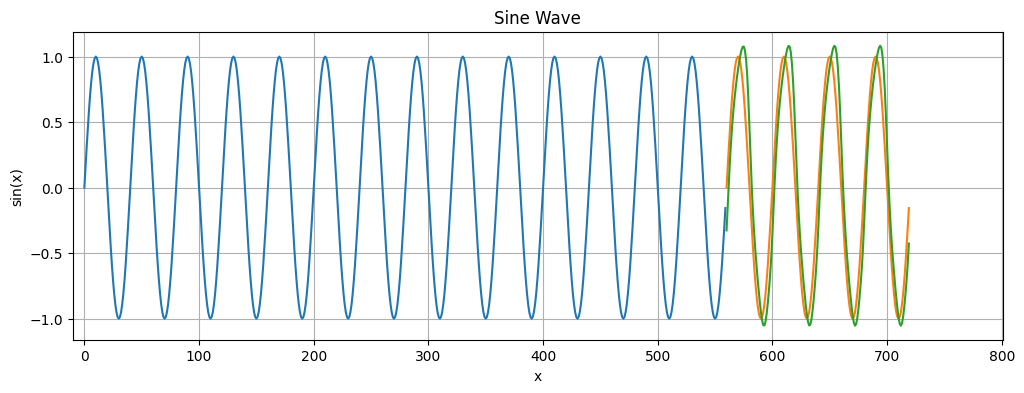

Epoch 8 Loss: 5.920277180848643e-05


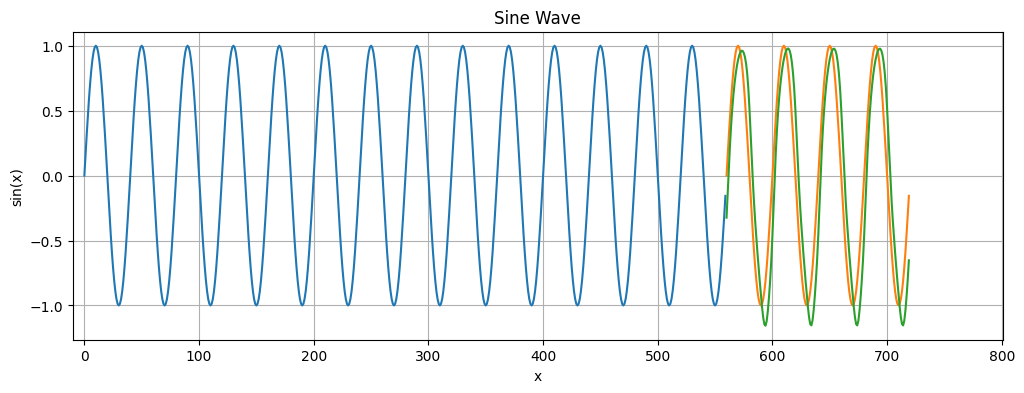

Epoch 9 Loss: 0.00017455445777159184


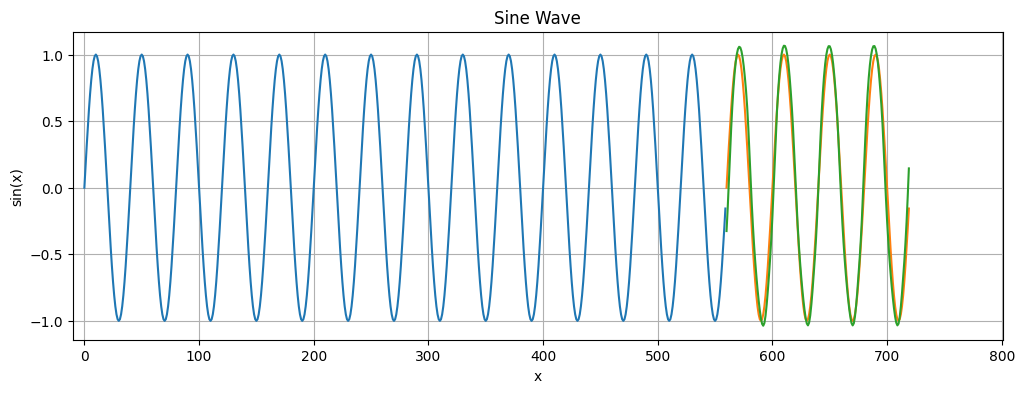

In [40]:
num_epochs = 10

for epoch in range(num_epochs):
    
    for i in range(num_sequences):
        optimizer.zero_grad()
        
        model.hidden = (torch.zeros(1,1,model.hidden_size),
                       torch.zeros(1,1,model.hidden_size))
        
        y_pred = model( training_sequences[i][0] )
        
        loss = loss_function(y_pred, training_sequences[i][1])
        loss.backward()
        optimizer.step()

    # The rest of this loop is not related to training, what does it do and why is it included?    
    print(f"Epoch {epoch} Loss: {loss.item()}")
    
    y_test_sequence = training_sequences[-1][0]
    y_test_prediction = []
    for i in range(num_test_datums):

        with torch.no_grad():
            model.hidden = (torch.zeros(1,1,model.hidden_size),
                           torch.zeros(1,1,model.hidden_size))
            
            next_guess = model(y_test_sequence)

        y_test_prediction.append(next_guess.item())
        y_test_sequence = torch.cat( (y_test_sequence[1:], next_guess))

    plot_helper()
    plt.plot(train_inds,train_y)
    plt.plot(test_inds, test_y)    
    plt.plot(test_inds, y_test_prediction )
    plt.show()